<a href="https://colab.research.google.com/github/danielka223/ds_workshop/blob/master/dsWorkshopAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="left">Helpfulness Prediction of Amazon Product Reviews</h1> 
<h2 align="left">DS Workshop - Fall 18/19 - Tel Aviv University</h2> 
<h3 align="left">By Daniel K.A, Ido Salomon, Itamar Mutzafi and Sagi Aharoni</h3> 




#Notebook Initialization
This section should only run once on a new runtime

In [56]:
#@title Install Required Packages

!pip install wordcloud
!pip install nltk
!pip install textstat
!pip install pyspellchecker
!pip install requests
!pip install tqdm
!pip install clint

In [57]:
#@title Import Python Libraries {display-mode: "form"}
import random
import os
import glob
import pandas as pd
import csv
import json
import datetime
from contextlib import contextmanager
from os.path import getsize, basename
import requests
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import gzip
from google.colab import files
from google.colab import drive
import pickle
import textstat
import math
from __future__ import print_function
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
from textblob import TextBlob
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import tokenize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import nltk
import string
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import minmax_scale
from spellchecker import SpellChecker
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
import gc
from clint.textui import progress
from tqdm import tqdm_notebook as tqdm
import requests
import time

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
#@title Choose Data Source {display-mode: "form"}

root = "drive/Team Drives/DS Workshop/"
TEST_SET_PICKLE = "Test_Set"
QUICKSAVE_PICKLE = "Quicksave"

PICKLE_TYPES = [TEST_SET_PICKLE, QUICKSAVE_PICKLE]

data_source = 'Google Drive' #@param ["Google Drive", "Local"]
load_non_neutral_datasets = True #@param {type:"boolean"} 
loaded_from_pickle = False

if (data_source == 'Google Drive'):
    # Connect to drive.
    drive.mount('/content/drive/')
elif data_source == 'Local':
    root = "./"
    
# make pickle_types directories
for pickle_type in PICKLE_TYPES:
    path = root + pickle_type
    if not os.path.exists(path):
      os.mkdir(path)

data_folder = root
if load_non_neutral_datasets:
    data_folder += "data_no_neutral/"
else:
    data_folder += "data/"

def pickleRead(pickle_type, filename):
    data_f = open(root + pickle_type + ("/%s.pickle" % filename), "rb")
    data = pickle.load(data_f)
    data_f.close()
    return data

def pickleWrite(pickle_type, variable, filename):
    saveData = open(root + pickle_type + ("/%s.pickle" % filename), "wb")
    pickle.dump(variable, saveData)
    saveData.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Local DB Fetching

In [59]:
def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()
  headers = {'Range':'bytes=0-'}
  response = session.get(URL,headers=headers, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)

  if token:
      params = { 'id' : id, 'confirm' : token }
      response = session.get(URL,headers=headers, params = params, stream = True)

  save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    rng = response.headers.get('Content-Range')
    cont_leng=int(rng.partition('/')[-1])
    pbar = tqdm(
        total=cont_leng, 
        unit='B', unit_scale=True, desc=destination)
    #assert 0 == 1
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                pbar.update(CHUNK_SIZE)
                
FILE_DB_ID = 0
FILE_DB_EXISTANCE = 1

FILE_DB_ORIG = "file_db"
FILE_DB_NO_NEUTRALS = "file_db_no_neutrals"

init_file_db_original = {
                "Apparel.tsv" : ("15J2qWrfixNZtuKP_rythZcdZ7jMBgJma", False),
                "Watches.tsv" : ("15Uorj0owdJrEeM1-EQgBeIv_jFHJUAw_", False),
                "Beauty.tsv" : ("150TLBOBgaSJeDXQ1YGIRb3meKGDBei20", False),
                "Baby.tsv" : ("152OE8vEvSe050QfyThf4pZXNtjV2Hb49", False),
                "Automotive.tsv" : ("15CJFjDB0g3bmg4xRWu7M4RPTSNB0Wdhu", False),
                "Books_v1_00.tsv" : ("14wLw92wpbeg1o50MDyQKGz_o-kHxBY9n", False),
                "Digital_Software.tsv" : ("14arSG9tVjhQq78mIOfctl4xo-lV1R-Df", False),
                "Digital_Music_Purchase.tsv" : ("14fNXNqT6xrvGNBzyNuBsPEMJ3Nvpl5cK", False),
                "Digital_Ebook_Purchase1.tsv" : ("14lWd7SfLLF7x4b91HXxG_9N3A8Oq305W", False),
                "Camera.tsv" : ("14lf-vbGN6WrCjOg-cQHF-qfqixlin44h", False),
                "Books.tsv" : ("14nY9vnmgr4a4UySg1yxdPD2zJfmxvfUP", False),
                "Digital_Ebook_Purchase.tsv" : ("14uKr9RzhV4rBUbMwSW4mF_5JGzdoq0en", False),
                "Books_v1_01.tsv" : ("14vp1Jt8-Z512T3JQ0ipUY0o_xsEkGKvD", False),
                "Health_Personal_Care.tsv" : ("13nj0saFtD1ZwQ93hU0simTJZ3tI7Knx5", False),
                "Grocery.tsv" : ("13qlyWRZ0MuGZaRSakQ3GfPh3AQTHwHqK", False),
                "Gift_Card.tsv" : ("13xvYHdHOpjbdAP4K5MHdmg9zQn2nbXj0", False),
                "Furniture.tsv" : ("144Wts_J9_PrWCeiQCp6WP-ESsbEPrj53", False),
                "Electronics.tsv" : ("1464Te5hMOaU5ZgqPtsyaFTebjdIJleVZ", False),
                "Digital_Video_Download.tsv" : ("14Vi6UYmHsrO6ydvqXLkUfV_x1k7oLQ_T", False),
                "Mobile_Apps.tsv" : ("13AQ3G65NYfrunooRGHFdvXQMB6AsNTLy", False),
                "Major_Appliances.tsv" : ("13PH1aq_dhoEPGfTs5eMbypvaP9E_yCyW", False),
                "Luggage.tsv" : ("13Y7lwdOtvYdvkP7Qpjwf3RusIwBTnP1B", False),
                "Lawn_and_Garden.tsv" : ("13ZtVB_ORCxrt9WBT5E1m8d0TFgfoylMT", False),
                "Kitchen.tsv" : ("13ipSTsOu-OFkavz5z7hONJrpojd5gk2F", False),
                "Jewelry.tsv" : ("13kC_eK-UavQlMoqtMu31M6dIB_-wNfzS", False),
                "Home_Improvement.tsv" : ("13l4eBvnbF9qZjTJBZOKhXe5n2XUhyevP", False),
                "Home_Entertainment.tsv" : ("13lZkUkrzNoJDL1G8GhC41MEFpdw0vCe8", False),
                "Home.tsv" : ("13mokMehSe4-V3cMDDc9D5fgK--dO-9dh", False),
                "Personal_Care_Appliances.tsv" : ("12qT3fZN7yGdtwl2d3iu-45cZ9VphhuwN", False),
                "PC.tsv" : ("12qtRsF0nidSK8D8QGEbRCSFZt19VJY_t", False),
                "Outdoors.tsv" : ("12tt2ShYdeer3T3wwu4L-8dz2P09em8pG", False),
                "Office_Products.tsv" : ("1309gBj2VUQ_AcF9LTG398NpduxRV0TwY", False),
                "Musical_Instruments.tsv" : ("130xSLM06hQoScqe8DinMwY-GV98oDljm", False),
                "Music.tsv" : ("134aIeU5qeld2kax1ZiBvPjEh1e3EjgtY", False),
                "Mobile_Electronics.tsv" : ("136CCh7Ux2VRkykqg9JvmrsolCFwqDgwe", False),
                "Video.tsv" : ("12ZcuCAGoqW-sbMY10pWZxKPj5kwrgtaj", False),
                "Toys.tsv" : ("12_yv9wq-cr_y9RJBGR2gFrpc7Zmz3VdS", False),
                "Tools.tsv" : ("12fZijUQFu3Ce-pA5piOBUYOqXUikkyEx", False),
                "Sports.tsv" : ("12gm91nEibXS-GkFoQo9Q5uoA6GpatqPO", False),
                "Software.tsv" : ("12i932su0Ofda7kMtZcfT-BXpLo4tk1vO", False),
                "Shoes.tsv" : ("12iKvxbhyi2yNqETHs-CdI0z3uX4s8P4T", False),
                "Pet_Products.tsv" : ("12qKBaGhFv9hKti4PAwDqQVCTfVbkUvdE", False),
                "Wireless.tsv" : ("1-6_fpo5NKoqHPXt5_6NJwTFX3i0-qrEy", False),
                "Video_Games.tsv" : ("1-82C-cpVxRIh1RSg-o62TYQkjWpAB6y-", False),
                "Digital_Video_Games.tsv" : ("1-8LKqrsJIzE0A0_dq8fYVLTcAoVZwTLA", False),
                "Video_DVD.tsv" : ("12TTXWbRFjkEAbZI81c3zkGd8bxC0Jfkf", False),
               }

init_file_db_no_neutrals = {
              "Apparel.tsv" : ("1-4TmWinZ4tHN5L9RLisCb1P3nrZ-ypAH", False),
              "Automotive.tsv" : ("1-5WYYYcDzsbpevpTEbo5wi4ah-jNJAZ6", False),
              "Baby.tsv" : ("1-D3NiXVK4JPLCvhLAM_UKzl0wxlEN_Z-", False),
              "Beauty.tsv" : ("1-FjxxpbwQT1VS4XHHeirfmtvoDpVsT09", False),
              "Books.tsv" : ("1q4YTPc92TH61N84IptA5jmo9d6VG2nC7", False),
              "Books_v1_00.tsv" : ("1jaG36ny5Yxa3qrgd0ELaK9KZw3OWeI-g", False),
              "Books_v1_01.tsv" : ("1I01c0IHrGN3HiuIoSAmjWn888fkow_pL", False),
              "Camera.tsv" : ("1-0bOjYAlc6a-UdTOS9fKAFdd0SvtF9_b", False),
              "Digital_Ebook_Purchase.tsv" : ("1-EqJBx11bUWydi14ro1SMpyUTdVMpXV2", False),
              "Digital_Ebook_Purchase1.tsv" : ("1in9tdxTNi2sYsuKH6Ve95R_R2SKznDFr", False),
              "Digital_Music_Purchase.tsv" : ("1--STpm2s2ryN4AgS3xlgyg7aRWyCkcjj", False),
              "Digital_Software.tsv" : ("1-4E8wJmPIWr7umopiVzoo5krQElNWxg3", False),
              "Digital_Video_Download.tsv" : ("1-5RLlE1gq-KOMI2YJmmrshkODQZSVcu3", False),
              "Digital_Video_Games.tsv" : ("1-6Cxfg-i0mjfLwjw57g8E6CmYxjtMvgn", False),
              "Electronics.tsv" : ("1-EJE-2bHcBwJ8qe10WtliFUsDWJOO6k6", False),
              "Furniture.tsv" : ("1-F3VGgr6OmgQjwx5fF9mBxZMEEKCiNby", False),
              "Gift_Card.tsv" : ("1-QDp7q3MAlE3bH2bh9O7TNN9tAgDHXt0", False),
              "Grocery.tsv" : ("1-R0XjkTXsF0q_6hUz1jCJtIEaMqrMsqW", False),
              "Health_Personal_Care.tsv" : ("1-TdLr00rb33npHZSr6Ylz-QUFS0k9amP", False),
              "Home.tsv" : ("1-UjWOBS_RmoA6rdo_3WbIJjNzAI2xUY1", False),
              "Home_Entertainment.tsv" : ("1-XCM3NWvWPGqLiNyWO3Ew9XxBkFfllCH", False),
              "Home_Improvement.tsv" : ("1-j13y-cFZ0lbEWmmTo9PIGgocqd8p3Mu", False),
              "Jewelry.tsv" : ("1-m9KkUCNQj2NohMc9sEDfKha-TYrHdWu", False),
              "Kitchen.tsv" : ("1-xUeXkAYCs7uT3PskwQZustMXLElolcE", False),
              "Lawn_and_Garden.tsv" : ("1-yQtwhBoTrm3bvNQ3LYvCAYwVW7wVtjB", False),
              "Luggage.tsv" : ("103mrM6BggbXtkOD0w_HvJ4CrHXqXPtkD", False),
              "Major_Appliances.tsv" : ("107CuhJa2UJeLYwe-ZR4KSe8lHDNO0AWY", False),
              "Mobile_Apps.tsv" : ("10Dike2qTaSp8TW2KsmZgsFrhjyStTGd-", False),
              "Mobile_Electronics.tsv" : ("10RaCEohA48HO0eKgDJE1L8pvn6ovwdKt", False),
              "Music.tsv" : ("10_MRpd8YfA6GJ1s6ABam43UmjQrYuclO", False),
              "Musical_Instruments.tsv" : ("10qp5c9A0CjNFtwiRzUnLfHBDtVjLGRFw", False),
              "Office_Products.tsv" : ("10ry-Tlt96GJeDUpTXIKT0EkU0gaAMz3L", False),
              "Outdoors.tsv" : ("10wXs21GRai_cdvCuEn1t81mAkkGfaqF6", False),
              "PC.tsv" : ("1104aR_2BeMMEaZSSGU7X_KysOREKR5AF", False),
              "Personal_Care_Appliances.tsv" : ("110FE0Td1RmnXwRSiWh-KD4EnsE5xgSvQ", False),
              "Pet_Products.tsv" : ("110Lx6y9ZVAjV0K5msVpFKLFtCVmZCHlm", False),
              "Shoes.tsv" : ("111NsKKmd211BX1OZAqIiLL-kH7U1PkxG", False),
              "Software.tsv" : ("115I2QAXROLomQ03yaLWgcLmVqxeBmyXW", False),
              "Sports.tsv" : ("11CfJfGFLEbvlCOBwAw6PnTcOU9LV4rou", False),
              "Tools.tsv" : ("11F6Ui-8VoXY6OD2FMnWZwJa2SjBAtdLu", False),
              "Toys.tsv" : ("11ITxlXQH2TguO87vDAAo6V0T3WBzKNKE", False),
              "Video.tsv" : ("11JH6KMNA3efFcAPkF9-x49CBj7MPNXIo", False),
              "Video_DVD.tsv" : ("11Mtp3vyG32xO_5cpbJjLutF-jtGkAYaw", False),
              "Video_Games.tsv" : ("11SZVW1IIuhJFCVaLwnAwnDuvavGqUHXD", False),
              "Watches.tsv" : ("11SwuJa4ba8Ppa982IRq0-36ySez4j6Ib", False),
              "Wireless.tsv" : ("11U8z7PQXFIuKVXI0Tr7vl8SEM4lLEdTy", False),
               }

if load_non_neutral_datasets:
  file_db_type = FILE_DB_NO_NEUTRALS
  init_file_db = init_file_db_no_neutrals
else:
  file_db_type = FILE_DB_ORIG
  init_file_db = init_file_db_original
  
if data_source == "Standalone": 
  try:
    # load file db for knowing which data files were already fetched
    file_db = pickle.load(open(root + file_db_type, "rb"))
    print('loaded pickle')
  except:
    # on first run - create new file db with all files marked as unavailalbe locally
    file_db = init_file_db
  for filename in file_db:
    if file_db[filename][FILE_DB_EXISTANCE] == False:
      # file not available locally - download from Google Driveå
      try: 
        print("downloading", filename)
        download_file_from_google_drive(file_db[filename][FILE_DB_ID], 
                                        root + data_folder + "/" + filename)
        file_db[filename][FILE_DB_EXISTANCE] = True
      except:
        print("failed downloading", filename)
  pickle.dump(file_db, open(root + file_db_type, "wb"))
print(file_sizes)

{'Apparel.tsv': 230221, 'Automotive.tsv': 153099, 'Baby.tsv': 107685, 'Beauty.tsv': 349724, 'Books.tsv': 1418511, 'Books_v1_00.tsv': 630435, 'Books_v1_01.tsv': 1495443, 'Camera.tsv': 191541, 'Digital_Ebook_Purchase.tsv': 360498, 'Digital_Ebook_Purchase1.tsv': 374650, 'Digital_Music_Purchase.tsv': 36312, 'Digital_Software.tsv': 8610, 'Digital_Video_Download.tsv': 74872, 'Digital_Video_Games.tsv': 9575, 'Electronics.tsv': 211890, 'Furniture.tsv': 80027, 'Gift_Card.tsv': 882, 'Grocery.tsv': 158741, 'Health_Personal_Care.tsv': 491054, 'Home.tsv': 413825, 'Home_Entertainment.tsv': 90273, 'Home_Improvement.tsv': 183164, 'Jewelry.tsv': 64333, 'Kitchen.tsv': 396753, 'Lawn_and_Garden.tsv': 219379, 'Luggage.tsv': 28784, 'Major_Appliances.tsv': 18321, 'Mobile_Apps.tsv': 381737, 'Mobile_Electronics.tsv': 5976, 'Music.tsv': 741615, 'Musical_Instruments.tsv': 77019, 'Office_Products.tsv': 187336, 'Outdoors.tsv': 175754, 'PC.tsv': 348331, 'Personal_Care_Appliances.tsv': 11981, 'Pet_Products.tsv': 165

In [0]:
#@title Infra Definitions

@contextmanager
def pbopen(filename, mode='r'):
    total = getsize(filename)
    pb = tqdm(total=total, unit="B", unit_scale=True,
              desc=basename(filename), miniters=1,
              ncols=80, ascii=True)

    def wrapped_line_iterator(fd):
        processed_bytes = 0
        for line in fd:
            processed_bytes += len(line)
            # update progress every MB.
            if processed_bytes >= 1024 * 1024:
                pb.update(processed_bytes)
                processed_bytes = 0

            yield line

        # finally
        pb.update(processed_bytes)
        pb.close()

    with open(filename, mode) as fd:
        yield wrapped_line_iterator(fd)
        
#decompress input folder to output folder
def ungzip(source_dir, dest_dir):
  for src_name in glob.glob(os.path.join(source_dir, '*.gz')):
      base = os.path.basename(src_name)
      dest_name = os.path.join(dest_dir, base[:-3])
      with gzip.open(src_name, 'rb') as infile:
          with open(dest_name, 'wb') as outfile:
              for line in infile:
                  outfile.write(line)

# Data Collection and Integration


In [61]:
file_ext = ".tsv"
file_names = sorted(glob.glob1(data_folder, "*" + file_ext))
file_names = file_names[8:]
print(file_names)

['Digital_Ebook_Purchase.tsv', 'Digital_Ebook_Purchase1.tsv', 'Digital_Music_Purchase.tsv', 'Digital_Software.tsv', 'Digital_Video_Download.tsv', 'Digital_Video_Games.tsv', 'Electronics.tsv', 'Furniture.tsv', 'Gift_Card.tsv', 'Grocery.tsv', 'Health_Personal_Care.tsv', 'Home.tsv', 'Home_Entertainment.tsv', 'Home_Improvement.tsv', 'Jewelry.tsv', 'Kitchen.tsv', 'Lawn_and_Garden.tsv', 'Luggage.tsv', 'Major_Appliances.tsv', 'Mobile_Apps.tsv', 'Mobile_Electronics.tsv', 'Music.tsv', 'Musical_Instruments.tsv', 'Office_Products.tsv', 'Outdoors.tsv', 'PC.tsv', 'Personal_Care_Appliances.tsv', 'Pet_Products.tsv', 'Shoes.tsv', 'Software.tsv', 'Sports.tsv', 'Tools.tsv', 'Toys.tsv', 'Video.tsv', 'Video_DVD.tsv', 'Video_Games.tsv', 'Watches.tsv', 'Wireless.tsv']


In [0]:
# Calculate the size for each category.
#@markdown ###Use precalculated sizes?
use_precalculated_sizes = True #@param {type:"boolean"}

if use_precalculated_sizes:
  if load_non_neutral_datasets:
    file_sizes = {
      'Apparel.tsv' : 230221,
      'Automotive.tsv' : 153099,
      'Baby.tsv' : 107685,
      'Beauty.tsv' : 349724,
      'Books.tsv' : 1418511,
      'Books_v1_00.tsv' : 630435,
      'Books_v1_01.tsv' : 1495443,
      'Camera.tsv' : 191541,
      'Digital_Ebook_Purchase.tsv' : 360498,
      'Digital_Ebook_Purchase1.tsv' : 374650,
      'Digital_Music_Purchase.tsv' : 36312,
      'Digital_Software.tsv' : 8610,
      'Digital_Video_Download.tsv' : 74872,
      'Digital_Video_Games.tsv' : 9575,
      'Electronics.tsv' : 211890,
      'Furniture.tsv' : 80027,
      'Gift_Card.tsv' : 882,
      'Grocery.tsv' : 158741,
      'Health_Personal_Care.tsv' : 491054,
      'Home.tsv' : 413825,
      'Home_Entertainment.tsv' : 90273,
      'Home_Improvement.tsv' : 183164,
      'Jewelry.tsv' : 64333,
      'Kitchen.tsv' : 396753,
      'Lawn_and_Garden.tsv' : 219379,
      'Luggage.tsv' : 28784,
      'Major_Appliances.tsv' : 18321,
      'Mobile_Apps.tsv' : 381737,
      'Mobile_Electronics.tsv' : 5976,
      'Music.tsv' : 741615,
      'Musical_Instruments.tsv' : 77019,
      'Office_Products.tsv' : 187336,
      'Outdoors.tsv' : 175754,
      'PC.tsv' : 348331,
      'Personal_Care_Appliances.tsv' : 11981,
      'Pet_Products.tsv' : 165006,
      'Shoes.tsv' : 161524,
      'Software.tsv' : 68214,
      'Sports.tsv' : 296677,
      'Tools.tsv' : 140003,
      'Toys.tsv' : 307859,
      'Video.tsv' : 100447,
      'Video_DVD.tsv' : 696093,
      'Video_Games.tsv' : 181240,
      'Watches.tsv' : 52999,
      'Wireless.tsv' : 288635
    }
  else:
    file_sizes = {
        'Apparel.tsv': 5906333, 
        'Automotive.tsv': 3514942,
        'Baby.tsv': 1752932,
        'Beauty.tsv': 5115666,
        'Books.tsv': 3105520, 
        'Books_v1_00.tsv': 10319090, 
        'Books_v1_01.tsv': 6106719, 
        'Camera.tsv': 1801974,
        'Digital_Ebook_Purchase.tsv': 5101693,
        'Digital_Ebook_Purchase1.tsv': 12520722,
        'Digital_Music_Purchase.tsv': 1688884, 
        'Digital_Software.tsv': 102084,
        'Digital_Video_Download.tsv': 4057147,
        'Digital_Video_Games.tsv': 145431,
        'Electronics.tsv': 3093869,
        'Furniture.tsv': 792113,
        'Gift_Card.tsv': 149086, 
        'Grocery.tsv': 2402458, 
        'Health_Personal_Care.tsv': 5331449, 
        'Home.tsv': 6221559,
        'Home_Entertainment.tsv': 705889,
        'Home_Improvement.tsv': 2634781,
        'Jewelry.tsv': 1767753,
        'Kitchen.tsv': 4880466,
        'Lawn_and_Garden.tsv': 2557288,
        'Luggage.tsv': 348657,
        'Major_Appliances.tsv': 96901, 
        'Mobile_Apps.tsv': 5033376, 
        'Mobile_Electronics.tsv': 104975, 
        'Music.tsv': 4751577, 
        'Musical_Instruments.tsv': 904765,
        'Office_Products.tsv': 2642434,
        'Outdoors.tsv': 2302401,
        'PC.tsv': 6908554,
        'Personal_Care_Appliances.tsv': 85981,
        'Pet_Products.tsv': 2643619, 
        'Shoes.tsv': 4366916,
        'Software.tsv': 341931,
        'Sports.tsv': 4850360,
        'Tools.tsv': 1741100,
        'Toys.tsv': 4864249,
        'Video.tsv': 380604,
        'Video_DVD.tsv': 5069140,
        'Video_Games.tsv': 1785997, 
        'Watches.tsv': 960872, 
        'Wireless.tsv': 9002021
      }
else:
  file_names = sorted(glob.glob1(data_folder, "*" + file_ext))
  file_sizes = {}
  print(file_names)
  for filename in file_names:
    num_lines = sum(1 for line in open(data_folder + filename))
    file_sizes[filename] = num_lines
    print(filename,str(num_lines))
    gc.collect()

##Load Data

In [0]:
#@markdown ###Data Loading
pick_category = "Video_DVD"  #@param ['All Categories', 'Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Books_v1_00', 'Books_v1_01', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Ebook_Purchase1', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garden', 'Luggage', 'Major_Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical_Instruments', 'Office_Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet_Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video_DVD', 'Video_Games', 'Watches', 'Wireless']
entry_limit = 1500000  #@param {type: "slider", min: 1000, max: 1500000, step:1000}
read_random_entries = True #@param {type:"boolean"}

include_all_categories = pick_category == "All Categories"



In [64]:
if include_all_categories:
  selected_paths = file_names
else:
  selected_paths = [pick_category + file_ext]
  
ds_list = []

if (not loaded_from_pickle):
  if (data_source == 'Google Drive'):
    read_per_part = entry_limit//len(selected_paths)
    for filename in selected_paths:
      print('Loading:', filename, '\n')
      if read_random_entries:
        numReviewsInCategory = max(file_sizes[filename]-1, 0)
        is_last_file = filename == selected_paths[-1]
        if is_last_file:
          num_rows_read = entry_limit-len(ds_list)*read_per_part
        else:
          num_rows_read = read_per_part
        skip = sorted(random.sample(range(1, numReviewsInCategory), numReviewsInCategory - min(numReviewsInCategory, num_rows_read)))
      else:
        skip = []
      cat_ds = pd.read_csv(data_folder+filename, 
                          delimiter='\t',
                          warn_bad_lines=True,
                          error_bad_lines=False,
                          skiprows = skip,
                          quoting=csv.QUOTE_NONE,
                          encoding="utf8")
      ds_list.append(cat_ds)
    reviews = pd.concat(ds_list, axis = 0, ignore_index = True)
  elif (data_source == 'Local Files'):
    reviews = pd.read_csv(data_folder+filename, 
                          encoding="utf8",
                          delimiter='\t',
                          warn_bad_lines=True,
                          error_bad_lines=False,
                          quoting=csv.QUOTE_NONE,
                          nrows=entry_limit)

Loading: Video_DVD.tsv 



##Data Overview

In [65]:
if (not loaded_from_pickle):
  print('Number of reviews:',reviews.shape[0])
  print('Description:')
  print(reviews.describe())
  print('Data types: \n')
  print(reviews.dtypes)
  display(reviews.head())
  display(reviews.tail())

Number of reviews: 696092
Description:
        customer_id  product_parent    star_rating  helpful_votes  \
count  6.960920e+05    6.960920e+05  696092.000000  696092.000000   
mean   3.694784e+07    5.021421e+08       3.761779      16.730892   
std    1.416590e+07    2.882013e+08       1.527463      49.232335   
min    1.257900e+04    1.658000e+03       1.000000       5.000000   
25%    2.462269e+07    2.505714e+08       3.000000       6.000000   
50%    4.032364e+07    5.054697e+08       5.000000       9.000000   
75%    5.035292e+07    7.551321e+08       5.000000      15.000000   
max    5.309656e+07    9.999931e+08       5.000000   20928.000000   

         total_votes  
count  696092.000000  
mean       22.215148  
std        55.531925  
min         5.000000  
25%         8.000000  
50%        12.000000  
75%        22.000000  
max     22982.000000  
Data types: 

marketplace          object
customer_id           int64
review_id            object
product_id           object
produc

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,45473710,R35H3NP0YC3RP2,B012XYQ1S0,958894482,Mission: Impossible - Rogue Nation,Video DVD,4,8,10,N,N,Good as ever was...,"The Impossible Mission Force is back, with a n...",2015-08-31
1,US,43430756,RZFNGJ341NYKD,B01169X9Z6,490379100,Self/less,Video DVD,3,7,9,N,N,THAT NEW BODY SMELL,EARLY PLOT SPOILER<br /><br />The best way to ...,2015-08-31
2,US,27636686,R24O5QQYIP3VYN,B00ZQ36S52,297087082,Max,Video DVD,5,9,9,N,N,Heroes Tell the Truth,The film Max easily falls into the category of...,2015-08-31
3,US,44783596,R31EUR60FV3BU5,B00ZGPZR9I,514136181,Wodehouse in Exile,Video DVD,4,32,39,N,N,Unfair Accusation Toward A Great BRITISH Author,Amazed after Wodehouse was interned by the Naz...,2015-08-31
4,US,21667088,R2W7WRBJVM6F7T,B001JAHSI2,578453087,The Simpsons: Season 18,Video DVD,1,12,15,N,N,Buy Chinese bootlegs,I do not have cable but The Simpsons? I repeat...,2015-08-31


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
696087,US,52807973,R3KYIA96PD8P8V,6304670117,844707900,Karaoke / Favorites 1,Video DVD,5,34,34,N,N,Information about Karaoke Favorites DVD,I thought that I would write a review of Karao...,1998-05-24
696088,US,52779201,RUHPCLZVJPEDT,6302224438,736462633,Objective Burma,Video DVD,5,19,20,N,N,Exceptional Combat Drama,Errol Flynn made several films about World War...,1998-04-17
696089,US,53016316,R1ASFG9TEUIHB9,6302797691,961914622,Bye Bye Birdie,Video DVD,5,6,6,N,N,Frothy Musical Fun from a Simpler America,Bye Bye Birdie is a delicious slice of musical...,1997-12-03
696090,US,52627645,R1PLYCHLSHISY6,6302533953,207666287,Newsies [VHS],Video DVD,4,15,18,N,N,A Wonderful Family Musical,The best thing about video is that movies whic...,1997-09-08
696091,US,53087071,R5GBJG2FG9B6U,6303197647,563746754,Alien Dreamtime,Video DVD,5,5,5,N,N,<P>Full sensory overload! <P>,Capturing a night of Terence Mckenna speaking ...,1996-07-08


#Data Preperation and Cleaning

In [66]:
print("There are %d reviews." % len(reviews))
#Cleanup in review text: <br>,<br/>,&#34;, [[...]]
reviews['review_body'] = reviews['review_body'].replace('\[\[.*\]\]|<.*br.*>',' ',regex=True)
reviews['review_body'] = reviews['review_body'].replace('&#34;|[^\x00-\x7F]+','',regex=True)
reviews['review_body'] = reviews['review_body'].apply(lambda text:str(text).strip())
reviews = reviews.dropna()
print("Cleared rows with NaN values, %d reviews left." % len(reviews))
reviews = reviews[reviews['review_body'].apply(lambda x : len(str(x))) > 3]
print("Cleared rows with very short (or empty) texts, %d reviews left." % len(reviews))
reviews = reviews.drop_duplicates(subset = ['customer_id','review_headline','review_body'] )
print("After drop_duplicates there are %d reviews." % len(reviews))


There are 696092 reviews.
Cleared rows with NaN values, 696086 reviews left.
Cleared rows with very short (or empty) texts, 695456 reviews left.
After drop_duplicates there are 694144 reviews.


#Data Visualization and Analysis

# Feature Selection and Engineering

In [0]:
def add_meta_features(dataset):
  dataset['helpful'] = ApplyHelpfulnessVector(dataset) 
  
def ApplyHelpfulnessVector(reviews):
  return reviews.apply(lambda row: isHelpful(row['total_votes'], row['helpful_votes']), axis=1)

def isHelpful(total_votes, helpful_votes):
  if   (total_votes >= 5 and helpful_votes >= (total_votes * 0.6)):
    return 1
  elif (total_votes >= 5 and helpful_votes < (total_votes * 0.6)):
    return -1
  else:
    return 0
    
if (not loaded_from_pickle):
  add_meta_features(reviews)
  # Add no. of helpful comments for each reviewer,total_helpful_votes_for_user,total_votes_for_user,reviewer_avg_rating, no. of helpful comments (that pass the threshold) for each reviewer
  commentCount=pd.DataFrame(reviews.groupby('customer_id').size())
  commentCount.columns=['commentCount']

  

In [0]:
reviews = reviews.set_index('customer_id').join(commentCount)
reviews = reviews.reset_index(drop=False) #drop=False to keep customer_id column.
reviews['commentCount'] = reviews['commentCount'] - 1 #comment history should not include current comment
helpfulRatingPerUser = pd.DataFrame(reviews.groupby('customer_id').sum())
helpfulRatingPerUser = helpfulRatingPerUser.drop(columns=['product_parent','star_rating','commentCount'])
helpfulRatingPerUser.columns=['total_helpful_votes_for_user','total_votes_for_user','userHelpfulness']
reviews = reviews.join(helpfulRatingPerUser, on='customer_id')
reviews['userHelpfulness'] = reviews['userHelpfulness'] - reviews['helpful']
reviews['total_helpful_votes_for_user'] = reviews['total_helpful_votes_for_user'] - reviews['helpful_votes']
reviews['total_votes_for_user'] = reviews['total_votes_for_user'] - reviews['total_votes']
reviews['reviewer_avg_rating'] = reviews['total_helpful_votes_for_user']/reviews['total_votes_for_user']
reviews['reviewer_avg_rating'] = reviews['reviewer_avg_rating'].fillna(0)


In [69]:
#@markdown ###Review Filters
def isBiggerDate(date1, date2):
  year1,month1,day1 = [int(x) for x in date1.split('-')]
  year2,month2,day2 = [int(x) for x in date2.split('-')]
  ydiff,mdiff,ddiff = year1-year2,month1-month2,day1-day2
  if (ydiff>0): return True;
  elif (ydiff<0): return False;
  if (mdiff>0): return True;
  elif (mdiff<0): return False;
  if (ddiff>0): return True;
  elif (ddiff<0): return False;
  return False

def get_set_info(subset):
  return { 'helpful': np.sum(subset['helpful']== 1),
           'neutral': np.sum(subset['helpful']== 0),
           'unhelpful': np.sum(subset['helpful']== -1) }

def print_set_info(name, set_info):
  print(name, 'set size:', sum(set_info.values()))
  print('* Helpful:', set_info['helpful'])
  print('* Neutral:', set_info['neutral'])
  print('* Unhelpful:', set_info['unhelpful'])
  print('** Total helpful + unhelpful:', set_info['helpful']+set_info['unhelpful'],'\n')
  
train_min_date = '2000-01-01'  #@param {type: "date"}
train_max_date = '2014-08-31'  #@param {type: "date"}
test_min_date = '2014-09-01'   #@param {type: "date"}
override_test_set = False       #@param {type: "boolean"}

if not (isBiggerDate(train_max_date,train_min_date)):
  assert False, 'Error: train_max_date must be bigger than train_min_date.\nPlease fix your dates selection.'
if not (isBiggerDate(test_min_date,train_max_date)):
  assert False, 'Error: test_min_date must be bigger than train_max_date.\nPlease fix your dates selection.'

# add columns to mark reviews which are part of the test/validation test  
reviews['isTestSet'] = False

train_set = reviews[(reviews['review_date'] > train_min_date) & (reviews['review_date'] < train_max_date)]

# test set should be constant (only created once in the project lifetime)
if (override_test_set) or (os.path.exists(root + TEST_SET_PICKLE + "/" + pick_category) == False):
    print('generating test set for the first time in the ds workflow lifetime!')
    test_set  = reviews[reviews['review_date'] > test_min_date] # test set + validation
     # mark examples used in test set
    test_set['isTestSet'] = True
    pickleWrite(TEST_SET_PICKLE, test_set, pick_category)
else:
    print('loading existing test set for category %s' % pick_category)
    test_set = pickleRead(TEST_SET_PICKLE, pick_category)

#test_set  = reviews[reviews['review_date'] > test_min_date]

train_info = get_set_info(train_set)
test_info = get_set_info(test_set)
print_set_info('Train', train_info)
print_set_info('Test', test_info)

generating test set for the first time in the ds workflow lifetime!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train set size: 662854
* Helpful: 546989
* Neutral: 0
* Unhelpful: 115865
** Total helpful + unhelpful: 662854 

Test set size: 27478
* Helpful: 23727
* Neutral: 0
* Unhelpful: 3751
** Total helpful + unhelpful: 27478 



## Bias Correction

In [0]:
#@markdown ###Train-Test Split 
test_set_size = 14000  #@param {type:"slider", min: 1000, max: 35000, step:1000}
test_set_percentage = 0.2  #@param {type:"slider", min: 0.2, max: 0.4, step:0.025}

#@markdown ###Bias Correction
correct_bias = True #@param {type:"boolean"}

num_test_no_neutral = test_info['helpful']+test_info['unhelpful']
if (test_set_size>num_test_no_neutral):
  assert False, 'Error: There aren\'t enough reviews in the test set.\nPlease reduce test_set_size below '+str(num_test_no_neutral)+'.'

if correct_bias:
  train_size_after_correction = 2*min(train_info['helpful'],train_info['unhelpful'])
  required_train_size = int(test_set_size/test_set_percentage-test_set_size)
  if (required_train_size>train_size_after_correction):
    assert False, 'Error: Can\'t correct bias and keep test:train ratio.\nPlease change test_set_percentage or increase test size.'


In [71]:
if (not loaded_from_pickle):
  print('Removing neutral reviews from the test set.')
  test_set = test_set[test_set['helpful'] != 0] # remove neutral reviews from test set
  test_set = test_set.sample(test_set_size)
  print("[TEST SET] model input (biased reviews): %d" % (test_set.shape[0]))
  
  #print_set_info('Train', train_info)
  
  if correct_bias:
    #Guaranteed to have enough reviews (see assertion in previous cell).
    df1 = train_set[train_set['helpful'] == 1].sample(n=required_train_size//2)
    df2 = train_set[train_set['helpful'] == -1].sample(n=required_train_size//2)
    unbiased_reviews = pd.concat([df1,df2])
  else:
    unbiased_reviews = train_set.sample(n=required_train_size)
    
  print("[TRAIN SET] model input (unbiased reviews):", unbiased_reviews.count()[0])
  
  unbiased_reviews = pd.concat([unbiased_reviews, test_set])
  print("Total data size = unbiased train set reviews + biased test set reviews:", unbiased_reviews.count()[0])

Removing neutral reviews from the test set.
[TEST SET] model input (biased reviews): 14000
[TRAIN SET] model input (unbiased reviews): 56000
Total data size = unbiased train set reviews + biased test set reviews: 70000


In [72]:
spell = SpellChecker()

def dateToInt(dateStr):
  year, month, day = dateStr.split('-')
  return 365*int(year)+30*int(month)+int(day)

def numWords(text):
  return len(re.findall("[a-zA-Z_]+", text))

def numSpellingMistakes(text):
  numMistakes = float(len(spell.unknown(text.split())))
  textLen = float(len(text))
  if (textLen<=0): return 0.0
  return numMistakes/textLen

def add_sentiment_statistics(df,column_title):
  split_sentences = []
  for index, row in df.iterrows():
    split_sentences.append(tokenize.sent_tokenize(row[column_title]))
    
  split_sentences = [[TextBlob(sentence).sentiment for sentence in review] for review in split_sentences]

  split_subjectivity = [[a.subjectivity for a in senten] for senten in split_sentences] 
  subjectivity_avg = [np.mean(review) for review in split_subjectivity]
  subjectivity_std = [np.std(review) for review in split_subjectivity]

  split_polarity = [[a.polarity for a in senten] for senten in split_sentences]
  polarity_avg = [np.mean(review) for review in split_polarity]
  polarity_std = [np.std(review) for review in split_polarity]

  df['subjectivity_avg'] = subjectivity_avg
  df['subjectivity_std'] = subjectivity_std
  df['polarity_avg'] = polarity_avg
  df['polarity_std'] = polarity_std
  

unbiased_reviews = unbiased_reviews.drop(['product_parent', 'product_id', 'review_id', 'customer_id', 'marketplace'], axis=1)
unbiased_reviews = unbiased_reviews.reset_index(drop=True)
data = unbiased_reviews

#Add text statistics, including length.
textStatistics = {
    'body_length' : len,
    'body_num_words' : numWords,
    'num_spelling_mistakes' : numSpellingMistakes,
    'flesch_reading_ease' : textstat.flesch_reading_ease,
    'smog_index' : textstat.smog_index,
    'flesch_kincaid_grade' : textstat.flesch_kincaid_grade,
    'coleman_liau_index' : textstat.coleman_liau_index,
    'automated_readability_index' : textstat.automated_readability_index,
    'dale_chall_readability_score' : textstat.dale_chall_readability_score,
    'difficult_words' : textstat.difficult_words,
    'linsear_write_formula' : textstat.linsear_write_formula,
    'gunning_fog' : textstat.gunning_fog,
}
  
for funcName in textStatistics:
  data.insert(0, funcName, 0.0)
  data[funcName] = data['review_body'].apply(lambda x: float(textStatistics[funcName](str(x))))
  print('Added',funcName,'column.')
#Convert the date column to integer.
data.insert(0, 'date_int', 0.0)
data['date_int'] = data['review_date'].apply(lambda x: float(dateToInt(str(x))))
  
add_sentiment_statistics(data,'review_body')

print(list(data.columns.values))


Added body_length column.
Added body_num_words column.
Added num_spelling_mistakes column.
Added flesch_reading_ease column.
Added smog_index column.
Added flesch_kincaid_grade column.
Added coleman_liau_index column.
Added automated_readability_index column.
Added dale_chall_readability_score column.
Added difficult_words column.
Added linsear_write_formula column.
Added gunning_fog column.
['date_int', 'gunning_fog', 'linsear_write_formula', 'difficult_words', 'dale_chall_readability_score', 'automated_readability_index', 'coleman_liau_index', 'flesch_kincaid_grade', 'smog_index', 'flesch_reading_ease', 'num_spelling_mistakes', 'body_num_words', 'body_length', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'helpful', 'commentCount', 'total_helpful_votes_for_user', 'total_votes_for_user', 'userHelpfulness', 'reviewer_avg_rating', 'isTestSet', 'subjectivity_avg', 'subjecti

# Model Training

In [0]:
#@markdown ###DL

# # CNN for the IMDB problem
# import numpy as np
# from keras.preprocessing.text import Tokenizer
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, Convolution1D, Flatten, Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers.embeddings import Embedding
# from keras.preprocessing.sequence import pad_sequences
# import re
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import pickle
# from keras.utils import np_utils
# import pandas as pd
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from keras.wrappers.scikit_learn import KerasClassifier


# data = reviews
# data = data.loc[:, ['review_body','helpful']]


# #Convert reviews text to lowercase
# data['text'] = data['review_body'].apply(lambda x: str(x).lower())
# #Remove all charactares appart from a-zA-z0-9 (for instance: punctuation)
# data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# #overallDistribution = data.overall.value_counts().sort_index()
# #print(overallDistribution)

# #Vocabulary size - Most 2000 common words
# #Convert input text to integer sequences
# max_features = 5000
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(data['text'].values)
# X = tokenizer.texts_to_sequences(data['text'].values)
# #cap the maximum review length at 500 words,
# #truncating reviews longer than that and
# # padding reviews shorter than that with 0 values.
# max_review_length = 500
# X = pad_sequences(X,  maxlen=max_review_length)

# # Using embedding from Keras
# embedding_vector_length = 32
# def baseline_model():
#     # create the model - Machine learning mastery
#     model = Sequential()
#     model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
#     model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     # model.add(Dropout(0.1))
#     model.add(Dense(250, activation='relu'))
#     # model.add(Dense(1, activation='sigmoid'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
#     return model

# Y = data['helpful']
# # Fit the model
# epochs_num = 2
# batchSize = 128

# model = KerasClassifier(build_fn=baseline_model, epochs=epochs_num, batch_size=batchSize, verbose=0)

# nsplits = 3
# kfold = KFold(n_splits=nsplits, shuffle=True, random_state=1)
# results = cross_val_score(model, X, Y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

##Non DL Models

In [0]:
def createBitDicts(inputNames):
  allDicts = []
  inputLen = len(inputNames)
  for i in range(2**inputLen):
    bits = [(i >> bit) & 1 for bit in range(inputLen - 1, -1, -1)]
    allDicts.append(dict(zip(inputNames, bits)))
  return allDicts

def createEnhancedParamDicts(inputNames):
  allDicts = []
  inputLen = len(inputNames)
  for i in range(2**inputLen):
    bits = [float(1 + ((i >> bit) & 1)) for bit in range(inputLen - 1, -1, -1)]
    allDicts.append(dict(zip(inputNames, bits)))
  return allDicts

#inputNames = [x[0] for x in union.transformer_list]
#createEnhancedParamDicts(inputNames)

In [0]:
original_forms = {}

class FeatureType:
    TEXTUAL = 1
    NUMERICAL = 2
    CATEGORICAL = 3
    
class FeatureCategory:
    HEADLINE = 1
    BODY = 2
    READABILITY = 3
    USER = 4
    SUBJECTIVITY = 5
    METADATA = 6
    
class QuickSaver(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, var):
        #print(var.shape)
        pickleWrite(QUICKSAVE_PICKLE, var, 'QuickSave_'+str(var.shape[0]))
        return var
      
class QuickLoader(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, var):
        var = pickleRead(QUICKSAVE_PICKLE, 'QuickSave_'+str(var.shape[0]))
        return var
class Debug(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, var):
        print(var)
        return var
      
def minmaxscale(df):
  for column in df:
    minmax_scale(df[column], copy=False)
  return df

def categoryVectorizer(cat):
  numerical_features = []
  categorical_features = []
  for x in modelFeatures:
    featureCategory = modelFeatures[x][0]
    if (featureCategory==cat):
      featureType = modelFeatures[x][1]
      if (featureType==FeatureType.NUMERICAL):
        numerical_features.append(x)
      elif (featureType==FeatureType.CATEGORICAL):
        categorical_features.append(x)
      else:
        print("Error: Unknown feature type.")
        
  if (len(numerical_features)!=0 and len(categorical_features)==0):
    return Pipeline([
          ('select'  , FunctionTransformer(lambda x: x[numerical_features].astype('f'), validate=False)),
          ('min_max' , FunctionTransformer(lambda x: minmaxscale(x), validate=False)),
          ('dict_lst', FunctionTransformer(lambda x: x.to_dict(orient='records'), validate=False)), # returns a list of dicts
          ('vect'    , DictVectorizer()),  # list of dicts -> feature matrix  
      ])
  elif (len(numerical_features)==0 and len(categorical_features)!=0):
    return Pipeline([
          ('select'  , FunctionTransformer(lambda x: x[categorical_features].astype('U'), validate=False)),
          ('dict_lst', FunctionTransformer(lambda x: x.to_dict(orient='records'), validate=False)), # returns a list of dicts
          ('vect'    , DictVectorizer()),  # list of dicts -> feature matrix  
      ])
  else:
    return FeatureUnion(transformer_list=[   
      # Pipeline - numerical features
      ('numeric', Pipeline([
          ('select'  , FunctionTransformer(lambda x: x[numerical_features].astype('f'), validate=False)),
          ('min_max' , FunctionTransformer(lambda x: minmaxscale(x), validate=False)),
          ('dict_lst', FunctionTransformer(lambda x: x.to_dict(orient='records'), validate=False)), # returns a list of dicts
          ('vect'    , DictVectorizer()),  # list of dicts -> feature matrix  
      ])),

      # Pipeline - categorical features
      ('category', Pipeline([
          ('select'  , FunctionTransformer(lambda x: x[categorical_features].astype('U'), validate=False)),
          ('dict_lst', FunctionTransformer(lambda x: x.to_dict(orient='records'), validate=False)), # returns a list of dicts
          ('vect'    , DictVectorizer()),  # list of dicts -> feature matrix  
      ])),
    ])

In [0]:
test_sentence = 'Let me start off by saying Cowin’s customer service is outstanding. mading solving solving solve The above mention issue was addressed, solved and I the customer made whole. I received the replacement item today. The product is all it’s made out to be. The sound is unbelievable coming from a product at this price. I am now purchasing a second device and a gift. Thank you Cowin, you have a new customer for life.'

english_stopwords = stopwords.words('english') + ['could', 'couldn\'t', 'could\'ve', 'i\'ve']
tokenizer_regex = RegexpTokenizer('^[a-zA-Z\']+$')
ess = SnowballStemmer('english', ignore_stopwords=True)

def best_tokenizer(sentence):
  tokens = tokenizer_regex.tokenize(sentence.replace(' ','\n'))
  tokens = [token.lower() for token in tokens]
  tokens = [token for token in tokens if token not in english_stopwords]

  stemmed = []
  for token in tokens:
    word_stem = ess.stem(token)
    stemmed.append(word_stem)
    
    # Compute original forms.
    if word_stem not in original_forms:
      original_forms[word_stem] = {token : 1}
    else:
      if token not in original_forms[word_stem]:
        original_forms[word_stem][token] = 1
      else:
        original_forms[word_stem][token] += 1

  return stemmed


#original_forms = {}
#best_tokenizer(test_sentence)
#original_forms

In [0]:
#@markdown ###Pipeline Options
selectKBest_k_value = 'all' 

body_selector = SelectKBest(chi2, k=selectKBest_k_value)
headline_selector = SelectKBest(chi2, k=selectKBest_k_value)

In [0]:
modelFeatures = {
    'review_headline' :              (0,    FeatureType.TEXTUAL),
    'review_body' :                  (1,        FeatureType.TEXTUAL),
    'flesch_reading_ease' :          (2, FeatureType.NUMERICAL),
    'smog_index' :                   (3, FeatureType.NUMERICAL),
    'flesch_kincaid_grade' :         (4, FeatureType.NUMERICAL),
    'coleman_liau_index' :           (5, FeatureType.NUMERICAL),
    'automated_readability_index' :  (6, FeatureType.NUMERICAL),
    'dale_chall_readability_score' : (7, FeatureType.NUMERICAL),
    'difficult_words' :              (8, FeatureType.NUMERICAL),
    'linsear_write_formula' :        (90, FeatureType.NUMERICAL),
    'gunning_fog' :                  (10, FeatureType.NUMERICAL),
    'commentCount' :                 (11,        FeatureType.NUMERICAL),
    'userHelpfulness' :              (12,        FeatureType.NUMERICAL),
    'body_length' :                  (91,        FeatureType.NUMERICAL),
    'body_num_words' :               (92,        FeatureType.NUMERICAL),
    'num_spelling_mistakes' :        (15,        FeatureType.NUMERICAL),
    'total_helpful_votes_for_user' : (16,        FeatureType.NUMERICAL),
    'total_votes_for_user' :         (17,        FeatureType.NUMERICAL),
    'reviewer_avg_rating' :          (18,        FeatureType.NUMERICAL),
    'subjectivity_avg' :             (19,FeatureType.NUMERICAL),
    'subjectivity_std' :             (20,FeatureType.NUMERICAL),
    'polarity_avg' :                 (21,FeatureType.NUMERICAL),
    'polarity_std' :                 (93,FeatureType.NUMERICAL),
    'star_rating' :                  (94,    FeatureType.NUMERICAL),
    'verified_purchase' :            (24,    FeatureType.CATEGORICAL),
}

union = FeatureUnion(
transformer_list=[
    #Pipeline - textual features
    ('head', Pipeline([
        ('select', FunctionTransformer(lambda x: x['review_headline'].astype('U'), validate=False)),
        ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=0.005, max_df=0.5, ngram_range=(1, 2), tokenizer=best_tokenizer, analyzer='word')),
        ('kbest', headline_selector),
    ])),

    #Pipeline - textual features
    ('body', Pipeline([
        ('select', FunctionTransformer(lambda x: x['review_body'].astype('U'), validate=False)),
        ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=0.005, max_df=0.5, ngram_range=(1, 2), tokenizer=best_tokenizer, analyzer='word')),
        ('kbest', body_selector),
    ])),
    
    # Pipeline - textual features
    ('cv90', categoryVectorizer(90)),
    ('cv91', categoryVectorizer(91)),
    ('cv92', categoryVectorizer(92)),
    ('cv93', categoryVectorizer(93)),
    ('cv94', categoryVectorizer(94)),
]
)

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
scoring = {'acc' : 'accuracy',
           'f1'  : 'f1', 
           'prec': 'precision', 
           'rec' : 'recall',
           'roc' : 'roc_auc',
           'tp'  : make_scorer(tp),
           'tn'  : make_scorer(tn),
           'fp'  : make_scorer(fp),
           'fn'  : make_scorer(fn)
          }

In [0]:
final_kbest = SelectKBest(chi2, k='all')

# shared pipeline for both cross val and formal train-test methods
inner_pipeline = Pipeline([
    #('qload', QuickLoader()),
    ('union', union), # Use FeatureUnion to combine the features from subject and body
    ('final-kbest', final_kbest), #Selects all - only for scoring.
    #('qsave', QuickSaver()),
    #('vote', VotingClassifier(estimators=[
    #('grid', GridSearchCV(LogisticRegression(solver='liblinear'), {'C':[15,17,19,21,23,25,27,29]}, cv=5)),
      ('clf', LogisticRegression(solver='liblinear')),
      #('clf1', SVC()),
      #('clf2', SGDClassifier(penalty='elasticnet',max_iter=50,tol=1e-3)),
      #('clf3', MultinomialNB(fit_prior=False)),
      #('clf4', RandomForestClassifier(n_estimators=200)),
    #], voting='soft')),
])

def train_model(data):
  global final_kbest
  
  test_set = data[data['isTestSet'] == True]

  train_set = data[data['isTestSet'] == False]
  
  X_train = train_set[list(modelFeatures.keys())]
  Y_train = train_set['helpful']
  X_test = test_set[list(modelFeatures.keys())]
  Y_test = test_set['helpful'] 

  clf = inner_pipeline
  clf.fit(X_train, Y_train)
  y = clf.predict(X_test)

  score_test_accuracy = metrics.accuracy_score(Y_test, y)
  score_test_f1 = metrics.f1_score(Y_test, y)
  score_test_precision = metrics.precision_score(Y_test, y)
  score_test_recall = metrics.recall_score(Y_test, y)
  quick_conf_mat = metrics.confusion_matrix(Y_test, y)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y)
  score_auc = auc(false_positive_rate, true_positive_rate)

  print("Model accuracy score: %.2f%%" % (100 * score_test_accuracy))
  print("Model f1 score: %.2f%%" % (100 * score_test_f1))
  print("Model precision: %.2f%%" % (100 * score_test_precision))
  print("Model recall: %.2f%%" % (100 * score_test_recall))
  print("Model AUC: %.2f%%" % (100 * score_auc))
  return clf, quick_conf_mat

def cross_val(data, gridSearchEn=False, kfolds=3):
  global final_kbest
  
  # select train data from unified train+test data
  train_set = data[data['isTestSet'] == False]
  
  # select train features and lables
  X_train = train_set[list(modelFeatures.keys())]
  Y_train = train_set['helpful']
  
  # init Grid Search Params  
  inputNames = [t[0] for t in union.transformer_list]
  dictsList = [#{'head': 1.0, 'body': 2.0, 'cv90': 1.0, 'cv91': 1.0, 'cv92': 1.0, 'cv93': 1.0, 'cv94': 1.0},
               #{'head': 1.0, 'body': 2.0, 'cv90': 1.3, 'cv91': 1.3, 'cv92': 1.3, 'cv93': 1.3, 'cv94': 1.3},
               {'head': 1.0, 'body': 2.0, 'cv90': 0.7, 'cv91': 0.7, 'cv92': 0.7, 'cv93': 0.7, 'cv94': 0.7}]
  param_grid = {
    'union__transformer_weights': dictsList,
    #'clf__C': [0.1, 0.3, 0.5, 0.7, 0.9],
  }
  
  # create pipeline used by cross validation (either created by Grid Search or constant)
  if gridSearchEn:
    search = GridSearchCV(inner_pipeline, param_grid, iid=False, cv=kfolds,
                          return_train_score=False, scoring='f1')
    clf = make_pipeline(search)
    clf.fit(X_train, Y_train)
    y = clf.predict(X_test)
    
    score_test_accuracy = metrics.accuracy_score(Y_test, y)
    score_test_f1 = metrics.f1_score(Y_test, y)
    score_test_precision = metrics.precision_score(Y_test, y)
    score_test_recall = metrics.recall_score(Y_test, y)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y)
    score_auc = auc(false_positive_rate, true_positive_rate)
  else:
    clf = inner_pipeline
    # define scorers for cross validation
    scoring = {'accuracy'  : make_scorer(accuracy_score), 
               'f1_score'  : make_scorer(f1_score),
               'precision' : make_scorer(precision_score),
               'recall'    : make_scorer(recall_score), 
               'roc_auc'    : make_scorer(roc_auc_score), 
               }

    kfold = KFold(n_splits=kfolds)
    results = cross_validate(estimator=clf,
                              X=X_train,
                              y=Y_train,
                              cv=kfold,
                              scoring=scoring,
                              verbose=10)
    
  if gridSearchEn:
    print("Best parameter combination (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
  else:  
    for scorer in scoring:
      key = "test_" + scorer
      print("********* Model mean %s score: %.2f%%, sdt: %.2f%% *********" % (scorer ,100 * np.mean(results[key]), np.std(results[key])))

In [80]:
cross_val(data.sample(n=10000), kfolds=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , accuracy=0.7415307402760352, f1_score=0.743142144638404, precision=0.7224242424242424, recall=0.7650834403080873, roc_auc=0.7420509226080314, total=  22.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  , accuracy=0.7558066541117389, f1_score=0.762660158633313, precision=0.7431629013079667, recall=0.7832080200501254, roc_auc=0.7557549534212891, total=  22.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  , accuracy=0.7482736974262398, f1_score=0.7517027863777089, precision=0.7183431952662722, recall=0.7883116883116883, roc_auc=0.7495628915434505, total=  22.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min remaining:    0.0s


[CV]  , accuracy=0.7407407407407407, f1_score=0.7516536380036081, precision=0.7548309178743962, recall=0.7485029940119761, roc_auc=0.7403464838133759, total=  22.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.6min remaining:    0.0s


[CV]  , accuracy=0.736346516007533, f1_score=0.7505938242280285, precision=0.7198177676537585, recall=0.7841191066997518, roc_auc=0.735769845598923, total=  22.3s
********* Model mean accuracy score: 74.45%, sdt: 0.01% *********
********* Model mean f1_score score: 75.20%, sdt: 0.01% *********
********* Model mean precision score: 73.17%, sdt: 0.01% *********
********* Model mean recall score: 77.38%, sdt: 0.01% *********
********* Model mean roc_auc score: 74.47%, sdt: 0.01% *********


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min finished


In [81]:
#Train model, Run on Test Set and print results.
pipeline, conf_mat = train_model(data)

Model accuracy score: 76.30%
Model f1 score: 84.79%
Model precision: 95.62%
Model recall: 76.15%
Model AUC: 76.71%


In [82]:
#Creates tf-idf dataset and heatmap

#headline is also below
'''
X = data['review_headline'].astype('U')
y = data['helpful']
tfidf = TfidfVectorizer()
sel_k_best = SelectKBest(chi2, k=20)
tfidf_matrix = tfidf.fit_transform(X)
X_new = sel_k_best.fit_transform(tfidf_matrix, y)

best_features_indices = sel_k_best.get_support(indices=True)
tfidf_all = tfidf.get_feature_names()
best_k_words = [tfidf_all[index] for index in best_features_indices]

df = pd.DataFrame(tfidf_matrix.todense())
droplist = [col for col in df.columns.values if col not in best_features_indices]
df = df.drop(droplist, axis=1)
all_columns = df.columns.values
new_names = {all_columns[i]:'headline_'+best_k_words[i] for i in range(len(all_columns))}
df = df.rename(index=str, columns=new_names)
best_scores = [sel_k_best.scores_[x] for x in best_features_indices]
sorted_cols = [x for _,x in sorted(zip(best_scores,df.columns.values))][::-1]
df = df.reindex(sorted_cols, axis=1)

#display(df.head(20))

import seaborn as sns
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
'''




"\nX = data['review_headline'].astype('U')\ny = data['helpful']\ntfidf = TfidfVectorizer()\nsel_k_best = SelectKBest(chi2, k=20)\ntfidf_matrix = tfidf.fit_transform(X)\nX_new = sel_k_best.fit_transform(tfidf_matrix, y)\n\nbest_features_indices = sel_k_best.get_support(indices=True)\ntfidf_all = tfidf.get_feature_names()\nbest_k_words = [tfidf_all[index] for index in best_features_indices]\n\ndf = pd.DataFrame(tfidf_matrix.todense())\ndroplist = [col for col in df.columns.values if col not in best_features_indices]\ndf = df.drop(droplist, axis=1)\nall_columns = df.columns.values\nnew_names = {all_columns[i]:'headline_'+best_k_words[i] for i in range(len(all_columns))}\ndf = df.rename(index=str, columns=new_names)\nbest_scores = [sel_k_best.scores_[x] for x in best_features_indices]\nsorted_cols = [x for _,x in sorted(zip(best_scores,df.columns.values))][::-1]\ndf = df.reindex(sorted_cols, axis=1)\n\n#display(df.head(20))\n\nimport seaborn as sns\ncorr = df.corr()\nsns.heatmap(corr, xtic

# Model Evaluation

## Feature Scores

In [83]:
def getLeafPipelines(toupleList):
  numPipelines = 0
  newToupleList = []
  for touple in toupleList:
    itemName = touple[0]
    item = touple[1]
    if (type(item)==Pipeline):
      newToupleList.append(touple)
      numPipelines += 1
    elif (type(item)==FeatureUnion):
      for newTouple in item.transformer_list:
        newToupleList.append((itemName+"-"+newTouple[0],newTouple[1]))
  if (numPipelines==len(toupleList)):
    return newToupleList
  return getLeafPipelines(newToupleList)

allPipelines = getLeafPipelines([('uni', union)])
print('Found',len(allPipelines),'pipeline leaves.')

Found 7 pipeline leaves.


In [84]:
#@title Features Score
import math

maximum_scores_on_screen = 40  #@param {type: "slider", min: 0, max: 1000, step:10}

all_features = []

for pipeTouple in allPipelines:
  smallPipeName = pipeTouple[0]
  smallPipe = pipeTouple[1]
  pipeSteps = list(smallPipe.named_steps.keys())
  if 'tfidf' in pipeSteps and 'kbest' in pipeSteps:
    feature_names = smallPipe.named_steps['tfidf'].get_feature_names()
    selected_k_indexes = smallPipe.named_steps['kbest'].get_support(indices=True)
    best_features_names = [feature_names[x] for x in selected_k_indexes]
    all_features += [smallPipeName+"="+x for x in best_features_names]
  elif 'vect' in pipeSteps:
    feature_names = smallPipe.named_steps['vect'].get_feature_names()
    all_features += feature_names
  else:
    print("Error: tfidf+kbest/vect not found in pipeline.")
    
#final_kbest = dict(pipeline.named_steps['gridsearchcv'].estimator.steps)['kbest']
selected_k_indexes = final_kbest.get_support(indices=True)
best_scores = [final_kbest.scores_[x] for x in selected_k_indexes]
sorted_best_features = sorted(zip(best_scores,all_features), reverse=True)

# Remove NaNs. This happens if transformer_weight=0 for some feature. 
sorted_best_features = [x for x in sorted_best_features if not math.isnan(x[0])]

for i in range(min(maximum_scores_on_screen, len(sorted_best_features))):
  x = sorted_best_features[i]
  print("%d. %s (score: %.2f)" % (i+1, x[1], x[0]))


1. star_rating (score: 5033.55)
2. uni-head=great (score: 386.78)
3. uni-head=worst (score: 227.11)
4. uni-head=dvd (score: 205.28)
5. uni-head=bore (score: 204.08)
6. uni-head=wast (score: 180.81)
7. uni-head=best (score: 178.69)
8. uni-body=wast (score: 178.43)
9. uni-head=excel (score: 174.30)
10. uni-head=fun (score: 131.14)
11. uni-head=aw (score: 130.35)
12. uni-body=dvd (score: 128.79)
13. uni-body=workout (score: 118.98)
14. uni-body=worst (score: 115.89)
15. uni-head=movi (score: 114.96)
16. uni-body=movi (score: 111.41)
17. uni-head=disappoint (score: 106.58)
18. uni-head=classic (score: 105.50)
19. uni-body=bore (score: 101.69)
20. uni-head=bad (score: 95.31)
21. uni-head=wonder (score: 91.34)
22. uni-head=love (score: 88.73)
23. uni-head=horribl (score: 78.93)
24. uni-body=high recommend (score: 74.99)
25. uni-body=worst movi (score: 74.73)
26. uni-body=bad (score: 72.44)
27. uni-head=terribl (score: 70.22)
28. uni-body=great (score: 70.03)
29. uni-body=wast time (score: 67

## TF-IDF Wordcloud

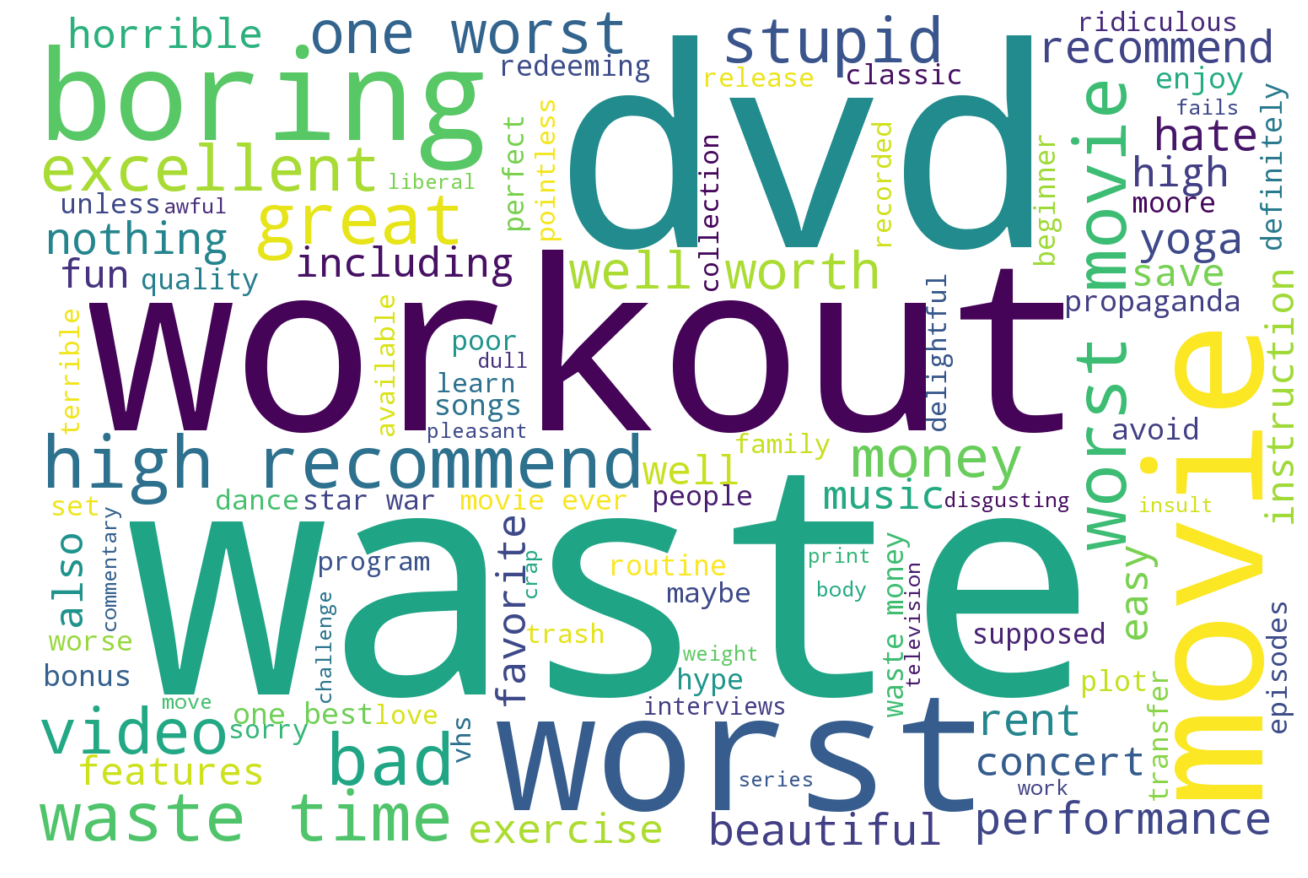

In [85]:
#Score
def most_common(lst):
    return max(lst, key=lst.get)

def get_original_form(ngram):
  ret = RegexpTokenizer('[a-zA-Z0-9\']+')
  tokens = ret.tokenize(ngram)
  if len(tokens) > 0:
    string= ""
    for t in tokens:
      string += most_common(original_forms[t])
      string += " "
    return string
  else:
    return ngram
  
bodyPipeline = [x[1] for x in allPipelines if x[0]=='uni-body'][0]
body_feature_names = bodyPipeline.named_steps['tfidf'].get_feature_names()
body_selected_k_indexes = bodyPipeline.named_steps['kbest'].get_support(indices=True)
best_features_names = [body_feature_names[x] for x in body_selected_k_indexes]
best_scores = [bodyPipeline.named_steps['kbest'].scores_[x] for x in body_selected_k_indexes]


sorted_best_features = sorted(zip(best_features_names, best_scores), reverse=True, key=lambda x: x[1])

sorted_best_features_original_form = {get_original_form(tup[0]) : tup[1] for tup in sorted_best_features}

# print(sorted_best_features)
# for x in sorted_best_features:
#   print("%s (score: %.4f)" % (x[0], x[1]))
  
# for x in sorted_best_features_original_form:
#   print("%s (score: %.4f)" % (x, sorted_best_features_original_form[x]))
  
wc = WordCloud(
    background_color="white",
    max_words=100,   
    width = 1500,
    height = 1000,
    #mask=mask,
)

# Generate the cloud

wc.generate_from_frequencies(sorted_best_features_original_form)

fig = plt.figure(
    figsize = (18, 12),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Results

## Plot Confusion Matrix

In [0]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual.iloc[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual.iloc[i]!=y_hat[i]:
           FP += 1
        if y_actual.iloc[i]==y_hat[i]==-1:
           TN += 1
        if y_hat[i]==-1 and y_actual.iloc[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

# if quick_test:
#   conf_mat = quick_conf_mat
#   print(conf_mat)
#   print("total helpful: ", Y_test[Y_test == 1].shape[0])
#   print("total unhelpful: ", Y_test[Y_test == -1].shape[0])
#   print(Y_test.iloc[0])
#   TP, FP, TN, FN = perf_measure(Y_test, y)
#   print("TP:",TP,"FP:",FP,"TN:",TN,"FN:",FN)

# else:
# conf_mat = [[sum(results['test_tn']), sum(results['test_fp'])],
#             [sum(results['test_fn']), sum(results['test_tp'])]]

# conf_mat = np.array(conf_mat)


Confusion matrix, without normalization
[[1437  423]
 [2895 9245]]


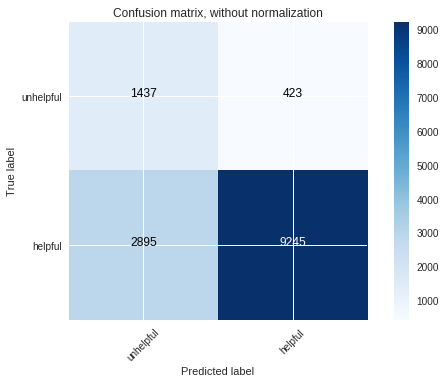

In [87]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['unhelpful','helpful'],
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(conf_mat, classes=['helpful','unhelpful'], normalize=True,
#                       title='Normalized confusion matrix')

plt.show()